In [1]:
import os
import sys

sys.path.insert(0, "../../")

import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

import pandas as pd
import warnings


warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', None)
import pathlib

from lips.augmented_simulators.tensorflow_models.powergrid import TfResNetPowerGrid

from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from lips.dataset.scaler import StandardScaler

from lips.config import ConfigManager
from lips.utils import get_path

In [2]:
# indicate required paths
LIPS_PATH = pathlib.Path().resolve().parent.parent # it is supposed that the notebook had run from getting_started folder
DATA_PATH = LIPS_PATH / "reference_data" / "powergrid" / "l2rpn_neurips_2020_track1_small"
BENCH_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "benchmarks" / "l2rpn_neurips_2020_track1_small.ini"
SIM_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "simulators"
BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
TRAINED_BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
EVALUATION_PATH = LIPS_PATH / "evaluation_results" / "PowerGrid"
LOG_PATH = LIPS_PATH / "lips_logs.log"

# 1. l2rpn_neurips_2020_track1_small grid

## 1.1 Benchmark2: Risk assessment through contingency screening

In [3]:
benchmark2 = PowerGridBenchmark(benchmark_name="Benchmark2",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH
                               )

In [4]:
bench_config = ConfigManager(section_name="Benchmark2", path=BENCH_CONFIG_PATH)
topo_actions = bench_config.get_option("dataset_create_params")["train"]["topo_actions"]

kwargs_tau = []
for el in topo_actions:
     kwargs_tau.append(el["set_bus"]["substations_id"][0])
                       
kwargs_tau

[(26, (2, 1, 1, 2, 1, 1, 1, 1, 1)),
 (26, (2, 2, 2, 1, 2, 1, 1, 1, 1)),
 (26, (2, 2, 1, 1, 2, 2, 1, 1, 1)),
 (23, (2, 2, 2, 2, 1, 1, 2, 2, 1, 2)),
 (23, (2, 2, 1, 2, 1, 1, 2, 2, 1, 1)),
 (23, (2, 1, 1, 1, 2, 2, 2, 2, 2, 2)),
 (23, (2, 2, 1, 1, 2, 2, 2, 1, 2, 2)),
 (16, (2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2)),
 (16, (2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1)),
 (16, (2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1)),
 (16, (2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2)),
 (16, (2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1)),
 (16, (2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2)),
 (16, (2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2)),
 (16, (1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)),
 (16, (1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1)),
 (9, (2, 2, 1, 1, 1, 1, 2)),
 (1, (2, 2, 1, 1, 2, 2)),
 (1, (2, 2, 1, 1, 1, 2)),
 (32, (2, 2, 1, 1, 1)),
 (4, (2, 1, 2, 2, 2, 1)),
 (4, (2, 2, 2, 2, 1, 1)),
 (28, (2, 1, 2, 1, 1))]

### Tensorflow ResNet 

In [5]:
tf_resnet = TfResNetPowerGrid(name="tf_resnet",
                         bench_config_path=BENCH_CONFIG_PATH,
                         bench_config_name="Benchmark2",
                         topo_vect_to_tau="given_list",
                         kwargs_tau=kwargs_tau,
                         #layers = [600, 600, 600, 600, 600],
                         layers = [400, 400, 400],
                         scale_input_layer = True,
                         lr = 1e-4,
                                      
                         loss = {"name": "mse"},
                         layer = "resnet",
                         activation = "elu",
                         sim_config_path=SIM_CONFIG_PATH / "tf_fc.ini",
                         sim_config_name="DEFAULT",
                         log_path=LOG_PATH,
                         scaler = StandardScaler,
                                     )

In [6]:
import time
start_time = time.time()

In [7]:
benchmark2._test_dataset.data["line_status"].shape

(50000, 59)

In [8]:
tf_resnet.train(train_dataset=benchmark2.train_dataset,
            val_dataset=benchmark2.val_dataset,
            batch_size = 128,
            epochs=400)

2022-07-22 14:08:04.407144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-22 14:08:04.853917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5120 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:03:00.0, compute capability: 8.6


Epoch 1/400
  39/1172 [..............................] - ETA: 4s - loss: 1.0574 - mae: 0.6765 

2022-07-22 14:08:07.762088: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1172/1172 [==============================] - 7s 5ms/step - loss: 0.1632 - mae: 0.2308 - val_loss: 0.0743 - val_mae: 0.1650
Epoch 2/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0492 - mae: 0.1338 - val_loss: 0.0447 - val_mae: 0.1248
Epoch 3/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0336 - mae: 0.1103 - val_loss: 0.0348 - val_mae: 0.1121
Epoch 4/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0264 - mae: 0.0981 - val_loss: 0.0282 - val_mae: 0.1004
Epoch 5/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0216 - mae: 0.0889 - val_loss: 0.0214 - val_mae: 0.0868
Epoch 6/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0180 - mae: 0.0814 - val_loss: 0.0187 - val_mae: 0.0829
Epoch 7/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0158 - mae: 0.0767 - val_loss: 0.0170 - val_mae: 0.0792
Epoch 8/400
1172/1172 [==============================] - 5s 5ms/ste

1172/1172 [==============================] - 6s 5ms/step - loss: 0.0017 - mae: 0.0255 - val_loss: 0.0029 - val_mae: 0.0324
Epoch 122/400
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0019 - mae: 0.0264 - val_loss: 0.0028 - val_mae: 0.0300
Epoch 123/400
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0017 - mae: 0.0251 - val_loss: 0.0024 - val_mae: 0.0280
Epoch 124/400
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0016 - mae: 0.0242 - val_loss: 0.0024 - val_mae: 0.0288
Epoch 125/400
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0017 - mae: 0.0257 - val_loss: 0.0021 - val_mae: 0.0258
Epoch 126/400
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0017 - mae: 0.0253 - val_loss: 0.0024 - val_mae: 0.0287
Epoch 127/400
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0018 - mae: 0.0258 - val_loss: 0.0025 - val_mae: 0.0283
Epoch 128/400
1172/1172 [==============================

Epoch 181/400
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0013 - mae: 0.0219 - val_loss: 0.0015 - val_mae: 0.0222
Epoch 182/400
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0012 - mae: 0.0214 - val_loss: 0.0016 - val_mae: 0.0227
Epoch 183/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0016 - mae: 0.0239 - val_loss: 0.0023 - val_mae: 0.0272
Epoch 184/400
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0012 - mae: 0.0205 - val_loss: 0.0015 - val_mae: 0.0215
Epoch 185/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0013 - mae: 0.0216 - val_loss: 0.0018 - val_mae: 0.0243
Epoch 186/400
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0013 - mae: 0.0215 - val_loss: 0.0016 - val_mae: 0.0226
Epoch 187/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0013 - mae: 0.0220 - val_loss: 0.0018 - val_mae: 0.0239
Epoch 188/400
1172/1172 [================

Epoch 241/400
1172/1172 [==============================] - 6s 5ms/step - loss: 9.9447e-04 - mae: 0.0192 - val_loss: 0.0013 - val_mae: 0.0203
Epoch 242/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0010 - mae: 0.0197 - val_loss: 0.0021 - val_mae: 0.0266
Epoch 243/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0011 - mae: 0.0200 - val_loss: 0.0014 - val_mae: 0.0214
Epoch 244/400
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0011 - mae: 0.0199 - val_loss: 0.0014 - val_mae: 0.0205
Epoch 245/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0011 - mae: 0.0198 - val_loss: 0.0020 - val_mae: 0.0254
Epoch 246/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0013 - mae: 0.0213 - val_loss: 0.0014 - val_mae: 0.0199
Epoch 247/400
1172/1172 [==============================] - 5s 5ms/step - loss: 9.6069e-04 - mae: 0.0186 - val_loss: 0.0012 - val_mae: 0.0188
Epoch 248/400
1172/1172 [========

1172/1172 [==============================] - 5s 5ms/step - loss: 9.3286e-04 - mae: 0.0182 - val_loss: 0.0011 - val_mae: 0.0186
Epoch 301/400
1172/1172 [==============================] - 5s 5ms/step - loss: 9.1638e-04 - mae: 0.0182 - val_loss: 0.0012 - val_mae: 0.0198
Epoch 302/400
1172/1172 [==============================] - 5s 5ms/step - loss: 9.1887e-04 - mae: 0.0184 - val_loss: 0.0012 - val_mae: 0.0186
Epoch 303/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0011 - mae: 0.0194 - val_loss: 0.0012 - val_mae: 0.0189
Epoch 304/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0010 - mae: 0.0188 - val_loss: 0.0018 - val_mae: 0.0250
Epoch 305/400
1172/1172 [==============================] - 5s 5ms/step - loss: 8.6296e-04 - mae: 0.0178 - val_loss: 0.0013 - val_mae: 0.0203
Epoch 306/400
1172/1172 [==============================] - 6s 5ms/step - loss: 9.5256e-04 - mae: 0.0187 - val_loss: 0.0012 - val_mae: 0.0195
Epoch 307/400
1172/1172 [==========

In [9]:
# print("--- %s seconds ---" % (time.time() - start_time))

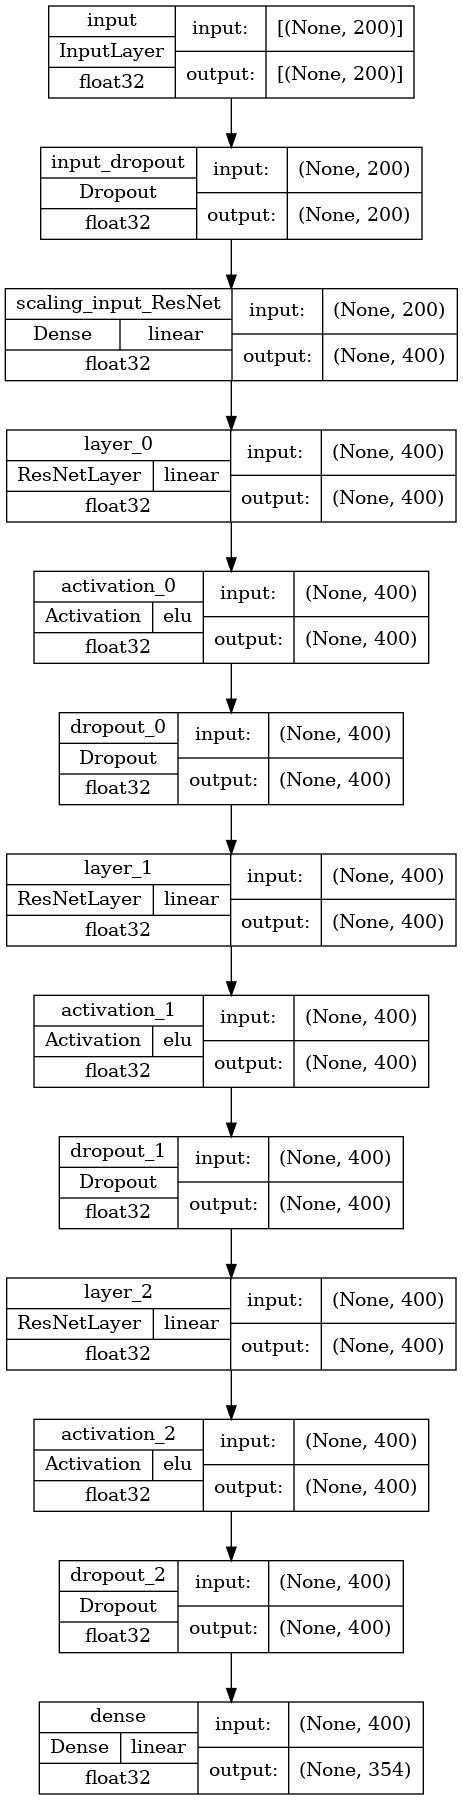

In [10]:
tf.keras.utils.plot_model(
    tf_resnet._model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations= True)

In [11]:
tf_resnet.summary()

Model: "tf_fc_DEFAULT_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200)]             0         
                                                                 
 input_dropout (Dropout)     (None, 200)               0         
                                                                 
 scaling_input_ResNet (Dense  (None, 400)              80400     
 )                                                               
                                                                 
 layer_0 (ResNetLayer)       (None, 400)               320800    
                                                                 
 activation_0 (Activation)   (None, 400)               0         
                                                                 
 dropout_0 (Dropout)         (None, 400)               0         
                                               

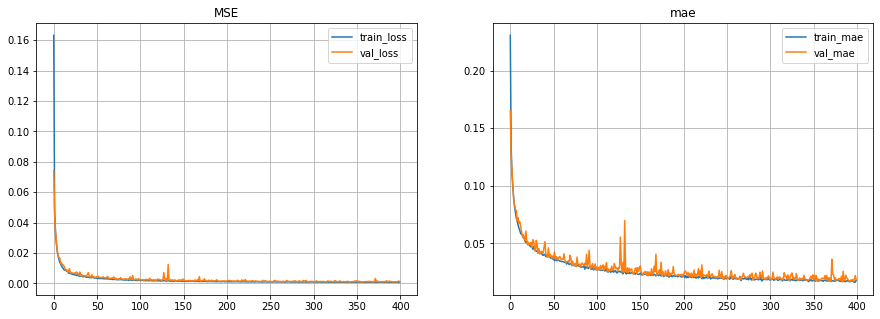

In [12]:
tf_resnet.visualize_convergence()

In [13]:
tf_fc_metrics2 = benchmark2.evaluate_simulator(augmented_simulator=tf_resnet,
                                              eval_batch_size=128,
                                              dataset="all",
                                              shuffle=False,
                                              save_predictions=True
                                             )

/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/venv/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:65: UserWarning: There were some Nan in the pp_net.trafo["tap_step_degree"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_degree\"], they have been replaced by 0")
/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/venv/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_slack.py:113: UserWarning: We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues
  warnings.warn("We found either some slack coefficient to be < 0. or they were all 0."


1/1 [==============================] - 0s 66ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/venv/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:65: UserWarning: There were some Nan in the pp_net.trafo["tap_step_degree"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_degree\"], they have been replaced by 0")
/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/venv/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_slack.py:113: UserWarning: We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues
  warnings.warn("We found either some slack coefficient to be < 0. or they were all 0."
100%|██████████| 50000/50000 [11:39<00:00, 71.46it/s]


50/50 [==============================] - 0s 2ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


1/1 [==============================] - 0s 43ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/venv/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:65: UserWarning: There were some Nan in the pp_net.trafo["tap_step_degree"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_degree\"], they have been replaced by 0")
/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/venv/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_slack.py:113: UserWarning: We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues
  warnings.warn("We found either some slack coefficient to be < 0. or they were all 0."
100%|██████████| 50000/50000 [11:35<00:00, 71.88it/s]


50/50 [==============================] - 0s 2ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


1/1 [==============================] - 0s 115ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/venv/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:65: UserWarning: There were some Nan in the pp_net.trafo["tap_step_degree"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_degree\"], they have been replaced by 0")
/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/venv/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_slack.py:113: UserWarning: We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues
  warnings.warn("We found either some slack coefficient to be < 0. or they were all 0."
100%|██████████| 150000/150000 [34:38<00:00, 72.18it/s]


150/150 [==============================] - 0s 2ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


In [14]:
SAVE_PATH = get_path(TRAINED_BASELINES_PATH, benchmark1)
tf_resnet.save(SAVE_PATH)

NameError: name 'benchmark1' is not defined

In [ ]:
import numpy as np
eval_metrics = tf_fc_metrics2

## A 

In [ ]:
a_test_list = [eval_metrics["test"]["ML"]["mape_90_avg"]["a_or"], eval_metrics["test"]["ML"]["mape_90_avg"]["a_ex"]]
a_ood_list = [eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"]["a_or"], eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"]["a_ex"]]

In [ ]:
print("ML : MAPE90 --> A : mean :{}, std :{}".format(np.mean(a_test_list), np.std(a_test_list)))
print("OOD : MAPE90 --> A : mean :{}, std :{}".format(np.mean(a_ood_list), np.std(a_ood_list)))

## P

In [ ]:
p_test_list = [eval_metrics["test"]["ML"]["mape_avg"]["p_or"], eval_metrics["test"]["ML"]["mape_avg"]["p_ex"]]
p_ood_list = [eval_metrics["test_ood_topo"]["ML"]["mape_avg"]["p_or"], eval_metrics["test_ood_topo"]["ML"]["mape_avg"]["p_ex"]]

In [ ]:
print("ML : MAPE --> P : mean :{}, std :{}".format(np.mean(p_test_list), np.std(p_test_list)))
print("OOD : MAPE --> P : mean :{}, std :{}".format(np.mean(p_ood_list), np.std(p_ood_list)))

## V 

In [ ]:
v_test_list = [eval_metrics["test"]["ML"]["MAE_avg"]["v_or"], eval_metrics["test"]["ML"]["MAE_avg"]["v_ex"]]
v_ood_list = [eval_metrics["test_ood_topo"]["ML"]["MAE_avg"]["v_or"], eval_metrics["test_ood_topo"]["ML"]["MAE_avg"]["v_ex"]]

In [ ]:
print("ML : MAE --> V : mean :{}, std :{}".format(np.mean(v_test_list), np.std(v_test_list)))
print("OOD : MAE --> V : mean :{}, std :{}".format(np.mean(v_ood_list), np.std(v_ood_list)))

## Inf speed-up

In [ ]:
print("ML : Inf speed-up :", eval_metrics["test"]["ML"]["TIME_INF"])

## Physics ML

In [ ]:
print("1) Current positivity violation:", (eval_metrics["test"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]+eval_metrics["test"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"])/2)#["a_or"]["Violation_proportion"]
print("2) Voltage positivity violation:", (eval_metrics["test"]["Physics"]["VOLTAGE_POS"]["v_or"]["Violation_proportion"]+eval_metrics["test"]["Physics"]["VOLTAGE_POS"]["v_ex"]["Violation_proportion"])/2)
print("3) Loss positivity violation:", eval_metrics["test"]["Physics"]["LOSS_POS"]["violation_proportion"])
print("4) Disconnected lines violation:", eval_metrics["test"]["Physics"]["DISC_LINES"])
print("5) Violation of loss to be between [1,4]% of production:", eval_metrics["test"]["Physics"]["CHECK_LOSS"]["violation_percentage"])
print("6) Violation of global conservation: {}% and its weighted mape: {}".format(eval_metrics["test"]["Physics"]["CHECK_GC"]["violation_percentage"], eval_metrics["test"]["Physics"]["CHECK_GC"]["wmape"]))
print("7) Violation of local conservation: {}% and its weighted mape: {}".format(eval_metrics["test"]["Physics"]["CHECK_LC"]["violation_percentage"], eval_metrics["test"]["Physics"]["CHECK_LC"]["mape"]))
print("8) Violation proportion of voltage equality at subs:", eval_metrics["test"]["Physics"]["CHECK_VOLTAGE_EQ"]["prop_voltages_violation"])

## Physics OOD

In [ ]:
print("1) Current positivity violation:", (eval_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]+eval_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"])/2)#["a_or"]["Violation_proportion"]
print("2) Voltage positivity violation:", (eval_metrics["test_ood_topo"]["Physics"]["VOLTAGE_POS"]["v_or"]["Violation_proportion"]+eval_metrics["test_ood_topo"]["Physics"]["VOLTAGE_POS"]["v_ex"]["Violation_proportion"])/2)
print("3) Loss positivity violation:", eval_metrics["test_ood_topo"]["Physics"]["LOSS_POS"]["violation_proportion"])
print("4) Disconnected lines violation:", eval_metrics["test_ood_topo"]["Physics"]["DISC_LINES"])
print("5) Violation of loss to be between [1,4]% of production:", eval_metrics["test_ood_topo"]["Physics"]["CHECK_LOSS"]["violation_percentage"])
print("6) Violation of global conservation: {}% and its weighted mape: {}".format(eval_metrics["test_ood_topo"]["Physics"]["CHECK_GC"]["violation_percentage"], eval_metrics["test_ood_topo"]["Physics"]["CHECK_GC"]["wmape"]))
print("7) Violation of local conservation: {}% and its weighted mape: {}".format(eval_metrics["test_ood_topo"]["Physics"]["CHECK_LC"]["violation_percentage"], eval_metrics["test_ood_topo"]["Physics"]["CHECK_LC"]["mape"]))
print("8) Violation proportion of voltage equality at subs:", eval_metrics["test_ood_topo"]["Physics"]["CHECK_VOLTAGE_EQ"][0][2])